# TLJH (The Littlest JupyterHub) Ansible Deployment

このノートブックでは、Ansibleを使用してリモートサーバーにTLJH + repo2dockerプラグインを自動デプロイします。

## 📋 構築内容
- mdx環境でのTLJHセットアップ
- Docker + Node.js環境の構築
- TLJH + tljh-repo2dockerプラグインのインストール
- HTTPS (Let's Encrypt) 設定（オプション）
- GPU対応設定（オプション）

## ⚠️ 前提条件
- リモートサーバーへのSSH接続が可能
    - 「VMへの公開鍵の登録」参照
- sudo権限を持つユーザーアカウント
- インターネット接続が可能
- ポート22/80/443が開放されている
    - ポート80/443を0.0.0.0/0に対して開放する
    - ポート22を、少なくとも以下のIPアドレスに対して開放する

In [ ]:
import requests
req = requests.get('https://ifconfig.me')
print("このJupyterのグローバルIPアドレス\n = " + req.text)

## 0. 設定変数の定義

デプロイメントに必要な基本設定を一箇所で定義します。環境に応じて以下の値を変更してください。

### 🔧 デプロイメント設定変数

以下の変数を環境に応じて変更してください

In [ ]:
import getpass

# リモートサーバー設定
REMOTE_HOST = "163.220.176.59"          # リモートサーバーのIPアドレス
REMOTE_USER = "mdxuser"                  # SSH接続用ユーザー名
SSH_KEY_FILE = "id_ed25519"

# 公開鍵のフルパス
ssh_dir = os.path.expanduser("~/.ssh")
SSH_KEY_PATH = os.path.join(ssh_dir, SSH_KEY_FILE)

# ネットワーク設定（REMOTE_HOSTから自動生成）
DOMAIN_NAME = f"ip-{REMOTE_HOST.replace('.', '-')}.compute.mdx1.jp"  # JupyterHub用ドメイン名（自動生成）
#DOMAIN_NAME = your.domain.ac.jp                                     # JupyterHub用ドメイン名（DNS設定）
EMAIL_ADDRESS = "matsumoto@nii.ac.jp"                       # Let's Encrypt用メールアドレス

# TLJH設定
TLJH_ADMIN_USER = "admin"                # JupyterHub管理者ユーザー名
#TLJH_ADMIN_PASSWORD = "admin123"         # JupyterHub管理者パスワード（本番では必ず変更）
TLJH_ADMIN_PASSWORD = getpass.getpass("JupyterHub管理者パスワードを入力してください: ")

In [ ]:
print("=== 設定変数確認 ===")
print(f"🎯 ターゲットサーバー: {REMOTE_HOST}")
print(f"👤 ユーザー: {REMOTE_USER}")
print(f"🔑 SSH鍵: {SSH_KEY_PATH}")
print(f"🌐 ドメイン名: {DOMAIN_NAME if DOMAIN_NAME else '未設定'}")
print(f"📧 メールアドレス: {EMAIL_ADDRESS if EMAIL_ADDRESS else '未設定'}")
print(f"👤 管理者ユーザー: {TLJH_ADMIN_USER}")
print("⚠️  本番環境では管理者パスワードを必ず変更してください")

if not DOMAIN_NAME:
    print("\n📝 HTTPS設定を行う場合は、DOMAIN_NAME を設定してください")
if not EMAIL_ADDRESS:
    print("📝 Let's Encrypt証明書を取得する場合は、EMAIL_ADDRESS を設定してください")

## 1. 鍵ペアの作成とVMの準備

### 鍵ペアの作成

デプロイ前にSSH接続の際に必要な鍵ペアを作成します。

In [ ]:
import os
import stat
import subprocess

# ~/.ssh がなければ作成
os.makedirs(ssh_dir, exist_ok=True)
os.chmod(ssh_dir, 0o700)

# 既存の鍵を削除
for ext in ["", ".pub"]:
    try:
        os.remove(SSH_KEY_PATH + ext)
        print(f"削除しました: {SSH_KEY_PATH + ext}")
    except FileNotFoundError:
        pass

# パスフレーズを入力（空ならパスフレーズなし）
passphrase = getpass.getpass("Passphrase を入力してください (空でも可): ")

# ssh-keygen コマンドを実行
# -N に空文字を渡せばパスフレーズなし
subprocess.run([
    "ssh-keygen", "-t", "ed25519", "-f", SSH_KEY_PATH, "-N", passphrase
])

# 念のため鍵のパーミッションを600に変更
for key_pair in [SSH_KEY_PATH, SSH_KEY_PATH + ".pub"]:
    os.chmod(key_pair, stat.S_IRUSR | stat.S_IWUSR)

print("新しい鍵を作成しました！")
if passphrase:
    print("パスフレーズ付き鍵です。")
else:
    print("パスフレーズのない鍵です。")

### 公開鍵の確認

In [ ]:
import shutil

# 隠しフォルダを表示できないので、ホームディレクトリにコピーする
src = os.path.expanduser(SSH_KEY_PATH + ".pub")
dst = os.path.expanduser("~/" + SSH_KEY_FILE + ".pub")
pubkey_copy = shutil.copy2(src, dst)
with open(pubkey_copy) as f:
    cat_pubkey = f.read()

print(cat_pubkey)

### VMへの公開鍵の登録

#### 新しくVMをデプロイする場合
この上に表示されている公開鍵を、mdxユーザーポータルでVMをデプロイするダイアログメニューの、公開鍵を入力するフォームに貼り付けます。  

<img width="400" src="pubkey_into_vm.png">

#### 既存のサーバーに追加する場合

SSHで接続できるターミナルから以下のいずれかの方法で追加してください。

* SSHでログインして、エディタで~/.ssh/known_hostsに上記公開鍵を追加
* ホームディレクトリにコピーされた公開鍵（id_ed25519.pub）をダウンロードする
    * ssh-copy-idが使える場合
        * `ssh-copy-id -f -i id_ed25519.pub mdxuser@ip-163-220-176-59.compute.mdx1.jp`
    * ssh-copy-idが使えない場合
        * `cat id_ed25519.pub | ssh mdxuser@ip-163-220-176-59.compute.mdx1.jp "mkdir -p ~/.ssh; cat >> ~/.ssh/authorized_keys"`

#### VMの準備完了の確認

全セル実行をした場合、ここでいったん止まりますので、上記設定が出来のを確認したらEnterキーを押してください。

In [ ]:
# pause の代わり
input("Enterを押してください。")

## 1. Ansibleの動的インベントリ設定

リモートサーバーの接続情報を含むAnsibleインベントリファイルを動的に生成します。

In [ ]:
# Ansibleインベントリファイルの作成
inventory_content = f"""[tljh_servers]
{REMOTE_HOST} ansible_user={REMOTE_USER} ansible_ssh_private_key_file={SSH_KEY_PATH}

[tljh_servers:vars]
ansible_become=yes
ansible_become_method=sudo
ansible_ssh_host_key_checking=False
ansible_ssh_common_args='-o StrictHostKeyChecking=no'
"""

# ansible.cfg設定
ansible_config = """[defaults]
inventory = ./inventory
host_key_checking = False
timeout = 30
gather_facts = yes
stdout_callback = yaml
retry_files_enabled = False

[ssh_connection]
ssh_args = -o ControlMaster=auto -o ControlPersist=60s -o StrictHostKeyChecking=no
pipelining = True
"""

# ファイルの書き込み
with open('inventory', 'w') as f:
    f.write(inventory_content)

with open('ansible.cfg', 'w') as f:
    f.write(ansible_config)

print("✅ Ansibleインベントリファイルを作成しました")
print("✅ Ansible設定ファイルを作成しました")

# インベントリファイルの内容確認
print("\n📄 インベントリファイルの内容:")
print("=" * 50)
print(inventory_content)
print("=" * 50)

## SSH接続の確立

## 2. SSH接続の確認

リモートサーバーへのSSH接続が正常に動作するかテストします。

In [ ]:
import re

output = subprocess.check_output(["ssh-agent", "-s"], text=True)

for line in output.splitlines():
    if "SSH_AUTH_SOCK" in line:
        os.environ["SSH_AUTH_SOCK"] = re.search(r'SSH_AUTH_SOCK=([^;]+)', line).group(1)
    if "SSH_AGENT_PID" in line:
        os.environ["SSH_AGENT_PID"] = re.search(r'SSH_AGENT_PID=([0-9]+)', line).group(1)

print("SSH_AUTH_SOCK =", os.environ["SSH_AUTH_SOCK"])
print("SSH_AGENT_PID =", os.environ["SSH_AGENT_PID"])

In [ ]:
import shlex

def run_ansible_command(command, show_output=True, announce=False):
    """Ansibleコマンドを実行する関数（文字列または引数リスト対応）
    
    Parameters
    ----------
    command : str | list
        実行するコマンド
    show_output : bool
        標準出力/標準エラーを表示するか
    announce : bool
        「🚀 実行中: ...」のメッセージを出すか
    """
    try:
        if isinstance(command, str):
            cmd_list = command.split()
        else:
            cmd_list = command

        if announce:
            print(f"🚀 実行中: {' '.join(cmd_list)}")

        result = subprocess.run(cmd_list, capture_output=True, text=True, timeout=300)

        if show_output:
            if result.stdout:
                print("📤 標準出力:")
                print(result.stdout)
            if result.stderr and result.returncode != 0:
                print("⚠️ エラー出力:")
                print(result.stderr)

        return result
    except subprocess.TimeoutExpired:
        print("⏰ コマンドがタイムアウトしました（5分）")
        return None
    except Exception as e:
        print(f"❌ コマンド実行エラー: {e}")
        return None

def run_ansible_command_list(host, module, args_dict=None, show_output=True):
    """Ansibleコマンドを引数リスト形式で実行する関数"""
    command = ["ansible", host, "-m", module]
    
    if args_dict:
        if isinstance(args_dict, str):
            command.extend(["-a", args_dict])
        else:
            # 辞書の場合は文字列に変換
            args_str = " ".join([f"{k}={v}" for k, v in args_dict.items()])
            command.extend(["-a", args_str])
    
    return run_ansible_command(command, show_output)

In [ ]:
# SSH接続テスト
print("=== SSH接続テスト ===")
result = run_ansible_command(f"ansible {REMOTE_HOST} -m ping")

if result and result.returncode == 0:
    print("✅ SSH接続成功！")
    
    # 基本的なシステム情報の取得
    print("\n=== システム情報取得 ===")
    result = run_ansible_command(f"ansible {REMOTE_HOST} -m setup -a filter=ansible_distribution*,ansible_kernel,ansible_memtotal_mb")
    
    if result and result.returncode == 0:
        print("✅ システム情報取得成功")
    else:
        print("⚠️ システム情報取得に失敗しました")
else:
    print("❌ SSH接続に失敗しました")
    print("   以下を確認してください:")
    print("   - SSH鍵のパスが正しいか")
    print("   - リモートサーバーが起動しているか")
    print("   - ネットワーク接続が正常か")
    print("   - ユーザー名が正しいか")

## 3. TLJHインストール用Playbookの作成

MDXマニュアルに基づいてTLJHのインストールに必要なAnsible Playbookを動的に生成します。

In [ ]:
# TLJH インストール用Playbookの作成
tljh_playbook = f"""---
- name: TLJH (The Littlest JupyterHub) Installation on MDX
  hosts: tljh_servers
  become: yes
  gather_facts: yes
  
  vars:
    admin_user: "{TLJH_ADMIN_USER}"
    admin_password: "{TLJH_ADMIN_PASSWORD}"
    tljh_version: "1.0.0"
    node_major: "21"
    r2d_image: "gcr.io/nii-ap-ops/repo2docker:2025.01.0"
    rdmfs_image: "gcr.io/nii-ap-ops/rdmfs:2024.12.0"

  tasks:
    - name: Update apt cache
      apt:
        update_cache: yes
        cache_valid_time: 3600

    - name: Install prerequisite packages
      apt:
        name:
          - apt-transport-https
          - ca-certificates
          - curl
          - software-properties-common
          - gnupg
          - lsb-release
        state: present

    - name: Remove old Docker packages (ignore errors)
      apt:
        name:
          - docker
          - docker-engine
          - docker.io
          - containerd
          - runc
        state: absent
      ignore_errors: yes

    - name: Create Docker keyring directory
      file:
        path: /etc/apt/keyrings
        state: directory
        mode: '0755'

    - name: Add Docker GPG key
      shell: |
        curl -fsSL https://download.docker.com/linux/ubuntu/gpg | gpg --dearmor -o /etc/apt/keyrings/docker.gpg
      args:
        creates: /etc/apt/keyrings/docker.gpg

    - name: Add Docker repository
      shell: |
        echo "deb [arch=$(dpkg --print-architecture) signed-by=/etc/apt/keyrings/docker.gpg] https://download.docker.com/linux/ubuntu $(. /etc/os-release && echo $VERSION_CODENAME) stable" | tee /etc/apt/sources.list.d/docker.list > /dev/null

    - name: Update apt cache after adding Docker repo
      apt:
        update_cache: yes

    - name: Install Docker
      apt:
        name:
          - docker-ce
          - docker-ce-cli
          - containerd.io
          - docker-buildx-plugin
          - docker-compose-plugin
        state: present

    - name: Start and enable Docker service
      systemd:
        name: docker
        state: started
        enabled: yes

    - name: Test Docker installation
      shell: docker run --rm hello-world
      register: docker_test
      ignore_errors: yes

    - name: Display Docker test result
      debug:
        msg: "Docker test: {{ 'SUCCESS' if docker_test.rc == 0 else 'FAILED' }}"

    - name: Create Node.js keyring directory
      file:
        path: /etc/apt/keyrings
        state: directory
        mode: '0755'

    - name: Add Node.js GPG key
      shell: |
        curl -fsSL https://deb.nodesource.com/gpgkey/nodesource-repo.gpg.key | gpg --dearmor -o /etc/apt/keyrings/nodesource.gpg
      args:
        creates: /etc/apt/keyrings/nodesource.gpg

    - name: Set permissions for Node.js keyring
      file:
        path: /etc/apt/keyrings/nodesource.gpg
        mode: '0644'

    - name: Add Node.js repository
      shell: |
        echo "deb [signed-by=/etc/apt/keyrings/nodesource.gpg] https://deb.nodesource.com/node_{{{{ node_major }}}}.x nodistro main" | tee /etc/apt/sources.list.d/nodesource.list

    - name: Update apt cache after adding Node.js repo
      apt:
        update_cache: yes

    - name: Install Node.js
      apt:
        name: nodejs
        state: present

    - name: Install yarn globally
      npm:
        name: yarn
        global: yes

    - name: Load FUSE kernel module
      modprobe:
        name: fuse
      ignore_errors: yes

    - name: Pre-pull Docker images (optional but recommended)
      shell: |
        docker pull "{{{{ r2d_image }}}}" || true
        docker pull "{{{{ rdmfs_image }}}}" || true
      ignore_errors: yes

    - name: Download and install TLJH
      shell: |
        curl -fsSL -L https://tljh.jupyter.org/bootstrap.py | python3 - --version "{{{{ tljh_version }}}}" --admin "{{{{ admin_user }}}}:{{{{ admin_password }}}}" --plugin git+https://github.com/RCOSDP/CS-tljh-repo2docker.git@master
      args:
        creates: /opt/tljh

    - name: Upgrade JupyterHub to fix compatibility issues
      shell: |
        /opt/tljh/hub/bin/pip install --upgrade "jupyterhub<5"

    - name: Create JupyterHub config directory
      file:
        path: /opt/tljh/config/jupyterhub_config.d
        state: directory
        mode: '0755'

    - name: Create repo2docker configuration
      copy:
        dest: /opt/tljh/config/jupyterhub_config.d/repo2docker.py
        content: |
          from tljh_repo2docker import TLJH_R2D_ADMIN_SCOPE
          import sys

          c.JupyterHub.allow_named_servers = True

          c.JupyterHub.services.extend(
              [
                  {{
                      "name": "tljh_repo2docker",
                      "url": "http://127.0.0.1:6789",
                      "command": [
                          sys.executable, "-m", "tljh_repo2docker",
                          "--ip", "127.0.0.1", "--port", "6789"
                      ],
                      "oauth_no_confirm": True,
                      "oauth_client_allowed_scopes": [
                          TLJH_R2D_ADMIN_SCOPE,
                      ],
                  }}
              ]
          )

          c.JupyterHub.custom_scopes = {{
              TLJH_R2D_ADMIN_SCOPE: {{
                  "description": "Admin access to tljh_repo2docker",
              }},
          }}

          c.JupyterHub.load_roles = [
              {{
                  "description": "Role for tljh_repo2docker service",
                  "name": "tljh-repo2docker-service",
                  "scopes": [
                      "read:users",
                      "read:roles:users",
                      "admin:servers",
                      "access:services!service=binder",
                  ],
                  "services": ["tljh_repo2docker"],
              }},
              {{
                  "name": "user",
                  "scopes": [
                      "self",
                      "access:services!service=tljh_repo2docker",
                  ],
              }},
              {{
                  "name": 'tljh-repo2docker-service-admin',
                  "groups": ["repo2docker"],
                  "scopes": [TLJH_R2D_ADMIN_SCOPE],
              }},
          ]

          c.JupyterHub.tornado_settings = {{
              "slow_spawn_timeout": 30
          }}
        mode: '0644'

    - name: Get JupyterHub major.minor version
      shell: |
        /opt/tljh/hub/bin/python -c 'import jupyterhub;print(".".join(jupyterhub.__version__.split(".")[:2]))'
      register: hub_version

    - name: Add default singleuser image
      shell: |
        tljh-config add-item docker.images "quay.io/jupyterhub/singleuser:{{{{ hub_version.stdout }}}}"
      ignore_errors: yes

    - name: Pull default singleuser image
      shell: |
        docker pull "quay.io/jupyterhub/singleuser:{{{{ hub_version.stdout }}}}"
      ignore_errors: yes

    - name: Reload TLJH configuration
      shell: tljh-config reload

    - name: Configure UFW firewall (if available)
      shell: |
        if command -v ufw >/dev/null 2>&1; then
          ufw allow OpenSSH || true
          ufw allow 80,443/tcp || true
        fi
      ignore_errors: yes

    - name: Restart JupyterHub service
      systemd:
        name: jupyterhub
        state: restarted

    - name: Wait for JupyterHub to start
      wait_for:
        port: 80
        host: "{{{{ ansible_default_ipv4.address }}}}"
        delay: 10
        timeout: 60

    - name: Check JupyterHub service status
      systemd:
        name: jupyterhub
      register: jupyterhub_status

    - name: Display installation summary
      debug:
        msg: |
          TLJH Installation completed successfully!
          - JupyterHub Status: {{{{ jupyterhub_status.status.ActiveState }}}}
          - Access URL: http://{{{{ ansible_default_ipv4.address }}}}/
          - Admin User: {{{{ admin_user }}}}
          - Admin Password: {{{{ admin_password }}}}
          - tljh-repo2docker plugin installed
"""

# Playbookファイルの作成
with open('tljh_playbook.yml', 'w') as f:
    f.write(tljh_playbook)

print("✅ TLJH インストール用Playbookを作成しました")
print("📄 ファイル名: tljh_playbook.yml")
print(f"📊 タスク数: {tljh_playbook.count('- name:')} タスク")
print("\n🎯 このPlaybookの主要な処理:")
print("   1. システムの前提パッケージ更新")
print("   2. Docker CE のインストール")
print("   3. Node.js + yarn のインストール")
print("   4. TLJH + repo2docker プラグインのインストール")
print("   5. JupyterHub設定とサービス起動")
print("   6. ファイアウォール設定（オプション）")


## 4. Ansibleを使用したTLJHのデプロイ

作成したPlaybookを実行し、リモートサーバーにTLJHをインストールします。この処理には10分程度かかる場合があります。

In [ ]:
import datetime
import time

print("=== TLJH デプロイメント開始 ===")
print(f"⏰ 開始時刻: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("⚠️  この処理には10分程度かかる場合があります。しばらくお待ちください...")

# 自動実行開始
start_time = time.time()

print("\n🚀 詳細ログモードで実行します...")
result = run_ansible_command("ansible-playbook tljh_playbook.yml -vvv")
end_time = time.time()
duration = int(end_time - start_time)

print(f"\n⏱️ 実行時間: {duration // 60}分{duration % 60}秒")

if result and result.returncode == 0:
    print("\n🎉 TLJH デプロイメント完了！")
    print("✅ すべてのタスクが正常に実行されました")
    
    # 成功時の情報表示
    print("\n" + "="*60)
    print("📋 デプロイメント完了情報")
    print("="*60)
    print(f"🌐 アクセスURL: http://{REMOTE_HOST}/")
    print(f"👤 管理者ユーザー: {TLJH_ADMIN_USER}")
    print(f"🔑 管理者パスワード: {TLJH_ADMIN_PASSWORD}")
    print("🔧 repo2docker プラグイン: インストール済み")
    print("📊 サービス: JupyterHub起動済み")
    print("="*60)
    
elif result:
    print("\n❌ デプロイメントでエラーが発生しました")
    print(f"   終了コード: {result.returncode}")
    
    # エラー詳細分析
    if result.stderr:
        print("\n🔍 エラー詳細分析:")
        error_lines = result.stderr.split('\n')
        for line in error_lines[-20:]:  # 最新20行のエラーを表示
            if line.strip() and ('ERROR' in line or 'FAILED' in line or 'fatal' in line):
                print(f"   ❌ {line.strip()}")
    
    # 標準出力からもエラー情報を抽出
    if result.stdout:
        print("\n📊 実行ログからの重要な情報:")
        output_lines = result.stdout.split('\n')
        for i, line in enumerate(output_lines):
            if 'TASK [' in line and i < len(output_lines) - 5:
                # タスクとその結果を表示
                task_name = line.strip()
                next_lines = output_lines[i+1:i+6]
                for next_line in next_lines:
                    if 'FAILED' in next_line or 'ERROR' in next_line:
                        print(f"   🔥 {task_name}")
                        print(f"      {next_line.strip()}")
                        break
                    elif 'ok:' in next_line or 'changed:' in next_line:
                        break
    
    print("\n🔧 次のステップ:")
    print("   1. 上記のエラー詳細を確認")
    print("   2. 必要に応じてPlaybookを修正")
    print("   3. インストール結果確認セルで現在の状態をチェック")
    
else:
    print("\n❌ コマンド実行自体が失敗しました")
    print("   • タイムアウトまたは予期しないエラーが発生")
    print("   • Ansibleの設定やネットワーク接続を確認してください")

## 5. インストール結果の確認

TLJHのインストールが正常に完了したかを確認し、サービスの状態をチェックします。

In [ ]:
print("=== インストール結果確認 ===")

# JupyterHubサービスの状態確認
print("\n1. JupyterHubサービス状態確認")
result = run_ansible_command(
    ["ansible", REMOTE_HOST, "-m", "service", "-a", "name=jupyterhub"],
    show_output=False
)
if result and result.returncode == 0:
    print("✅ JupyterHubサービス: 正常")
else:
    print("❌ JupyterHubサービス: 異常")

# Dockerサービスの状態確認
print("\n2. Dockerサービス状態確認")
result = run_ansible_command(
    ["ansible", REMOTE_HOST, "-m", "service", "-a", "name=docker"],
    show_output=False
)
if result and result.returncode == 0:
    print("✅ Dockerサービス: 正常")
else:
    print("❌ Dockerサービス: 異常")

# ポート確認（80番ポートでJupyterHubが起動しているか）
print("\n3. ポート80でJupyterHub起動確認")
result = run_ansible_command(
    ["ansible", REMOTE_HOST, "-m", "shell", "-a", "ss -tlnp | grep ':80'"],
    show_output=False
)
if result and result.returncode == 0 and result.stdout:
    print("✅ ポート80: JupyterHub起動中")
    print(f"   詳細: {result.stdout.strip()}")
else:
    print("❌ ポート80: JupyterHub未起動")

# tljh-repo2dockerプラグインの確認
print("\n4. tljh-repo2dockerプラグイン確認")
result = run_ansible_command(
    ["ansible", REMOTE_HOST, "-m", "shell", "-a", "/opt/tljh/hub/bin/pip list | grep tljh-repo2docker", "-b"],
    show_output=False
)
if result and result.returncode == 0 and result.stdout:
    print("✅ tljh-repo2dockerプラグイン: インストール済み")
    print(f"   バージョン: {result.stdout.strip()}")
else:
    print("❌ tljh-repo2dockerプラグイン: 未インストール")

# TLJH設定確認
print("\n5. TLJH設定ファイル確認")
result = run_ansible_command(
    ["ansible", REMOTE_HOST, "-m", "shell", "-a", "ls -la /opt/tljh/config/jupyterhub_config.d/", "-b"],
    show_output=False
)
if result and result.returncode == 0:
    print("✅ TLJH設定ディレクトリ: 存在")
    if 'repo2docker.py' in result.stdout:
        print("✅ repo2docker.py設定ファイル: 存在")
    else:
        print("❌ repo2docker.py設定ファイル: 不在")
else:
    print("❌ TLJH設定ディレクトリ: 不在")

# システムリソース確認
print("\n6. システムリソース確認")
result = run_ansible_command(
    ["ansible", REMOTE_HOST, "-m", "shell", "-a", "free -h && df -h /"],
    show_output=False
)
if result and result.returncode == 0:
    print("✅ システムリソース情報取得成功")
    lines = result.stdout.strip().split('\n')
    for line in lines:
        if 'Mem:' in line or '/' in line and 'G' in line:
            print(f"   {line}")

print("\n" + "="*60)
print("📋 アクセス情報")
print("="*60)
print(f"🌐 URL: http://{REMOTE_HOST}/")
print(f"👤 ユーザー: {TLJH_ADMIN_USER}")
print(f"🔑 パスワード: {TLJH_ADMIN_PASSWORD}")
print("📝 備考: 初回ログイン後、必ずパスワードを変更してください")
print("="*60)

## 6. HTTPS設定（Let's Encrypt）

JupyterHubにHTTPS（SSL/TLS）を設定し、Let's Encryptで無料のSSL証明書を取得します。

### 📋 前提条件
- ドメイン名がサーバーのIPアドレスを正しく指している
- ポート443（HTTPS）が開放されている
- Let's Encrypt用のメールアドレスが準備済み

### ⚠️ 注意事項
- 証明書の取得には数分かかる場合があります
- DNS設定が正しくない場合は失敗します
- 既存のHTTP接続も維持されます

In [ ]:
print("🔒 HTTPS設定（Let's Encrypt）")
print("="*60)

# tljh-configのパス設定
tljh_config_path = "/usr/bin/tljh-config"
print(f"使用するtljh-configパス: {tljh_config_path}")

# 1. 事前確認
print("\n1. 事前確認")
print("-" * 30)

# tljh-configの存在確認
config_check = run_ansible_command([
    "ansible", REMOTE_HOST, "-m", "shell", 
    "-a", f"test -f {tljh_config_path} && echo 'OK' || echo 'NG'"
], show_output=False)

if config_check and config_check.returncode == 0 and 'OK' in config_check.stdout:
    print("✅ tljh-config: 利用可能")
    
    # JupyterHub状態確認
    service_check = run_ansible_command([
        "ansible", REMOTE_HOST, "-m", "shell", 
        "-a", "systemctl is-active jupyterhub"
    ], show_output=False)
    
    if service_check and service_check.returncode == 0 and 'active' in service_check.stdout:
        print("✅ JupyterHub: 実行中")
        ready_for_https = True
    else:
        print("❌ JupyterHub: 停止中または異常")
        ready_for_https = False
else:
    print("❌ tljh-config: 利用不可")
    ready_for_https = False

# 2. HTTPS設定の実行
if ready_for_https:
    print("\n2. HTTPS設定実行")
    print("-" * 30)
    
    # ドメイン名とメールアドレスの設定確認
    domain_name = DOMAIN_NAME if DOMAIN_NAME else input("\nドメイン名を入力してください（例: hub.example.com）: ").strip()
    if not domain_name:
        print("❌ ドメイン名が必要です。設定を終了します。")
        print("   DOMAIN_NAME変数を設定するか、手動で入力してください。")
    else:
        email = EMAIL_ADDRESS if EMAIL_ADDRESS else input("Let's Encrypt用のメールアドレスを入力: ").strip()
        if not email:
            print("❌ メールアドレスが必要です。設定を終了します。")
            print("   EMAIL_ADDRESS変数を設定するか、手動で入力してください。")
        else:
            print(f"\n🌐 ドメイン: {domain_name}")
            print(f"📧 メール: {email}")
            
            # HTTPS設定コマンドの引数リスト形式での実行
            https_commands = [
                {
                    "name": "HTTPS有効化",
                    "cmd": ["ansible", REMOTE_HOST, "-m", "shell", "-a", f"{tljh_config_path} set https.enabled true"]
                },
                {
                    "name": "Let's Encryptメール設定",
                    "cmd": ["ansible", REMOTE_HOST, "-m", "shell", "-a", f"{tljh_config_path} set https.letsencrypt.email {email}"]
                },
                {
                    "name": "ドメイン追加",
                    "cmd": ["ansible", REMOTE_HOST, "-m", "shell", "-a", f"{tljh_config_path} add-item https.letsencrypt.domains {domain_name}"]
                },
                {
                    "name": "プロキシ再読み込み",
                    "cmd": ["ansible", REMOTE_HOST, "-m", "shell", "-a", f"{tljh_config_path} reload proxy"]
                }
            ]
            
            print("\n🔧 HTTPS設定コマンド実行:")
            success_count = 0
            
            for i, cmd_info in enumerate(https_commands, 1):
                print(f"\n{i}. {cmd_info['name']}")
                
                result = run_ansible_command(cmd_info['cmd'], show_output=False)
                
                if result and result.returncode == 0:
                    print(f"✅ 成功")
                    success_count += 1
                    if result.stdout.strip():
                        print(f"   出力: {result.stdout.strip()}")
                else:
                    print(f"❌ 失敗")
                    if result:
                        print(f"   終了コード: {result.returncode}")
                        if result.stderr:
                            error_line = result.stderr.split('\n')[0]
                            print(f"   エラー: {error_line}")
                    break
            
            # 結果表示
            if success_count == len(https_commands):
                print("\n🎉 HTTPS設定完了！")
                print("\n📋 次のステップ:")
                print("   • Let's Encrypt証明書の取得には数分かかります")
                print("   • ドメイン名がサーバーIPを正しく指している必要があります")
                print(f"   • https://{domain_name} でアクセスをお試しください")
                print("\n💡 証明書取得の確認:")
                print(f"   • 数分後に https://{domain_name} でアクセス")
                print("   • エラーが出る場合はDNS設定を確認")
            else:
                print(f"\n❌ HTTPS設定が完了しませんでした（{success_count}/{len(https_commands)}成功）")
                print("\n🔧 推奨トラブルシューティング:")
                print("   1. DNS設定を確認（ドメインがIPを正しく指しているか）")
                print("   2. ファイアウォール設定を確認（ポート443が開放されているか）")
                print("   3. サーバーに直接SSHアクセスして詳細確認")
else:
    print("\n❌ HTTPS設定の前提条件が満たされていません")
    print("\n🔧 解決策:")
    print("   1. TLJHが正常にインストールされているか確認")
    print("   2. JupyterHubサービスが正常に動作しているか確認")
    print("   3. 必要に応じてTLJHを再インストール")

print("\n" + "="*60)

## 7. GPU設定（オプション）

NVIDIA GPUを使用可能にするための設定を行います。この設定により、JupyterHubでGPU対応のコンテナを実行できるようになります。

### 📋 前提条件
- NVIDIA GPUがインストールされている
- NVIDIA Driverがインストール済み
- NVIDIA Container Toolkitのサポート

### ⚠️ 注意事項
- GPU設定は任意です（GPUがない環境では実行しないでください）
- 設定変更後はJupyterHubの再起動が必要
- GPU対応コンテナのビルド時間が長くなる場合があります

In [ ]:
print("🎮 GPU設定（オプション）")
print("="*60)

# GPU設定を自動実行
print("\n1. システムGPU情報確認")
print("-" * 30)

# GPU情報の確認
gpu_check = run_ansible_command([
    "ansible", REMOTE_HOST, "-m", "shell", 
    "-a", "lspci | grep -i nvidia || echo 'NVIDIA GPU not found'"
], show_output=False)

if gpu_check and gpu_check.returncode == 0:
    if 'NVIDIA GPU not found' in gpu_check.stdout:
        print("❌ NVIDIA GPUが見つかりません")
        print("   GPU設定をスキップします")
        gpu_available = False
    else:
        print("✅ NVIDIA GPU検出:")
        for line in gpu_check.stdout.strip().split('\n'):
            if line.strip():
                print(f"   {line}")
        gpu_available = True
else:
    print("❌ GPU情報の取得に失敗しました")
    gpu_available = False

if gpu_available:
    print("\n2. NVIDIA Container Runtime設定")
    print("-" * 30)
    
    # 従来の構築手順に基づくGPU設定コマンド
    gpu_commands = [
        {
            "name": "パッケージリストの更新",
            "cmd": ["ansible", REMOTE_HOST, "-m", "apt", "-b", "-a", "update_cache=yes"]
        },
        {
            "name": "NVIDIA Container Runtime インストール",
            "cmd": ["ansible", REMOTE_HOST, "-m", "apt", "-b", "-a", "name=nvidia-container-runtime state=present"]
        },
        {
            "name": "Docker用ランタイムの自動設定",
            "cmd": ["ansible", REMOTE_HOST, "-m", "shell", "-b", "-a", "nvidia-ctk runtime configure --runtime=docker"]
        },
        {
            "name": "Docker サービス再起動",
            "cmd": ["ansible", REMOTE_HOST, "-m", "systemd", "-b", "-a", "name=docker state=restarted"]
        }
    ]
    
    print("🔧 NVIDIA Container Runtime設定実行:")
    gpu_success_count = 0
    
    for i, cmd_info in enumerate(gpu_commands, 1):
        print(f"\n{i}. {cmd_info['name']}")
        
        result = run_ansible_command(cmd_info['cmd'], show_output=False)
        
        if result and result.returncode == 0:
            print("✅ 成功")
            gpu_success_count += 1
            if result.stdout and result.stdout.strip():
                print(f"   出力: {result.stdout.strip()}")
        else:
            print("❌ 失敗")
            if result:
                print(f"   終了コード: {result.returncode}")
                if result.stderr:
                    error_line = result.stderr.split('\n')[0]
                    print(f"   エラー: {error_line}")
            break
    
    if gpu_success_count == len(gpu_commands):
        print("\n3. GPU動作確認")
        print("-" * 30)
        
        # GPU動作確認
        gpu_test = run_ansible_command([
            "ansible", REMOTE_HOST, "-m", "shell", "-b", "-a",
            "docker run --gpus all --rm nvidia/cuda:12.3.1-base-ubuntu22.04 nvidia-smi"
        ], show_output=True)
        
        if gpu_test and gpu_test.returncode == 0:
            print("✅ GPU動作確認成功")
            
            print("\n4. Hub側Docker SDK確認・インストール")
            print("-" * 30)
            
            # Docker SDKの確認・インストール
            docker_sdk_check = run_ansible_command([
                "ansible", REMOTE_HOST, "-m", "shell", "-b", "-a",
                "/opt/tljh/hub/bin/python -c 'import docker' || /opt/tljh/hub/bin/pip install --no-cache-dir docker"
            ], show_output=False)
            
            if docker_sdk_check and docker_sdk_check.returncode == 0:
                print("✅ Docker SDK確認・インストール完了")
                
            print("\n5. JupyterHub GPU設定ファイル作成")
            print("-" * 30)
            
            # GPU設定ファイルの内容
            gpu_config_content = '''import docker

# Give DockerSpawner containers access to all GPUs (equivalent to `--gpus all`)
c.DockerSpawner.extra_host_config = {
    "device_requests": [
        docker.types.DeviceRequest(
            count=-1,              # all GPUs
            capabilities=[["gpu"]],
        ),
    ],
}'''
            
            # GPU設定ファイルの作成
            config_create = run_ansible_command([
                "ansible", REMOTE_HOST, "-m", "shell", "-b", "-a",
                f'mkdir -p /opt/tljh/config/jupyterhub_config.d && echo \'{gpu_config_content}\' > /opt/tljh/config/jupyterhub_config.d/enable_gpu.py'
            ], show_output=False)
            
            if config_create and config_create.returncode == 0:
                print("✅ GPU設定ファイル作成完了")
                
                # パーミッション調整
                permission_set = run_ansible_command([
                    "ansible", REMOTE_HOST, "-m", "shell", "-b", "-a",
                    "chown root:root /opt/tljh/config/jupyterhub_config.d/enable_gpu.py && chmod 0644 /opt/tljh/config/jupyterhub_config.d/enable_gpu.py"
                ], show_output=False)
                
                if permission_set and permission_set.returncode == 0:
                    print("✅ パーミッション設定完了")
                    
                    print("\n6. JupyterHub再起動")
                    print("-" * 30)
                    
                    # JupyterHub再起動
                    hub_restart = run_ansible_command([
                        "ansible", REMOTE_HOST, "-m", "systemd", "-b", "-a",
                        "name=jupyterhub state=restarted"
                    ], show_output=False)
                    
                    if hub_restart and hub_restart.returncode == 0:
                        print("✅ JupyterHub再起動完了")
                        
                        print("\n🎉 GPU設定完了！")
                        print("\n📋 GPU設定確認方法:")
                        print("   1. JupyterHubにログイン")
                        print("   2. 新しいNotebook/Terminalを開始")
                        print("   3. 以下のコマンドでGPU確認:")
                        print("      !nvidia-smi")
                        print("      import torch; print(torch.cuda.is_available())")
                        
                        print("\n💡 エラーログ確認:")
                        print("   sudo journalctl -u jupyterhub -f でエラーログを確認してください")
                        
                    else:
                        print("❌ JupyterHub再起動に失敗しました")
                else:
                    print("❌ パーミッション設定に失敗しました")
            else:
                print("❌ GPU設定ファイル作成に失敗しました")
        else:
            print("❌ Docker SDK確認・インストールに失敗しました")
    else:
        print("❌ GPU動作確認に失敗しました")
        print("   NVIDIA Driverが正しくインストールされているか確認してください")
else:
    print(f"\n❌ NVIDIA Container Runtime設定が完了しませんでした（{gpu_success_count}/{len(gpu_commands)}成功）")
    print("\n🔧 解決策:")
    print("   1. NVIDIA Driverが正しくインストールされているか確認")
    print("   2. nvidia-container-runtimeパッケージの利用可能性を確認")
    print("   3. 手動でNVIDIA Container Runtimeをインストール")
print("\n" + "="*60)

## 8. Gakunin RDMとの連携

TLJHの起動が確認できたら、[Gakunin RDMの外部解析基盤との連携マニュアル](https://support.rdm.nii.ac.jp/usermanual/DataAnalysis-06/)内の「**3. GakuNin Federated Computing Services アドオンの構成」以降**を参考に、Gakunin RDMとの連携を行うことで、解析環境をTLJH内で起動することができます。

1. **Gakunin RDMからアドオンを設定**
    - アドオンから、Gakunin Federated Computing Servicesを有効化し、BinderHubを追加から、今回作成したTLJHを登録します。

    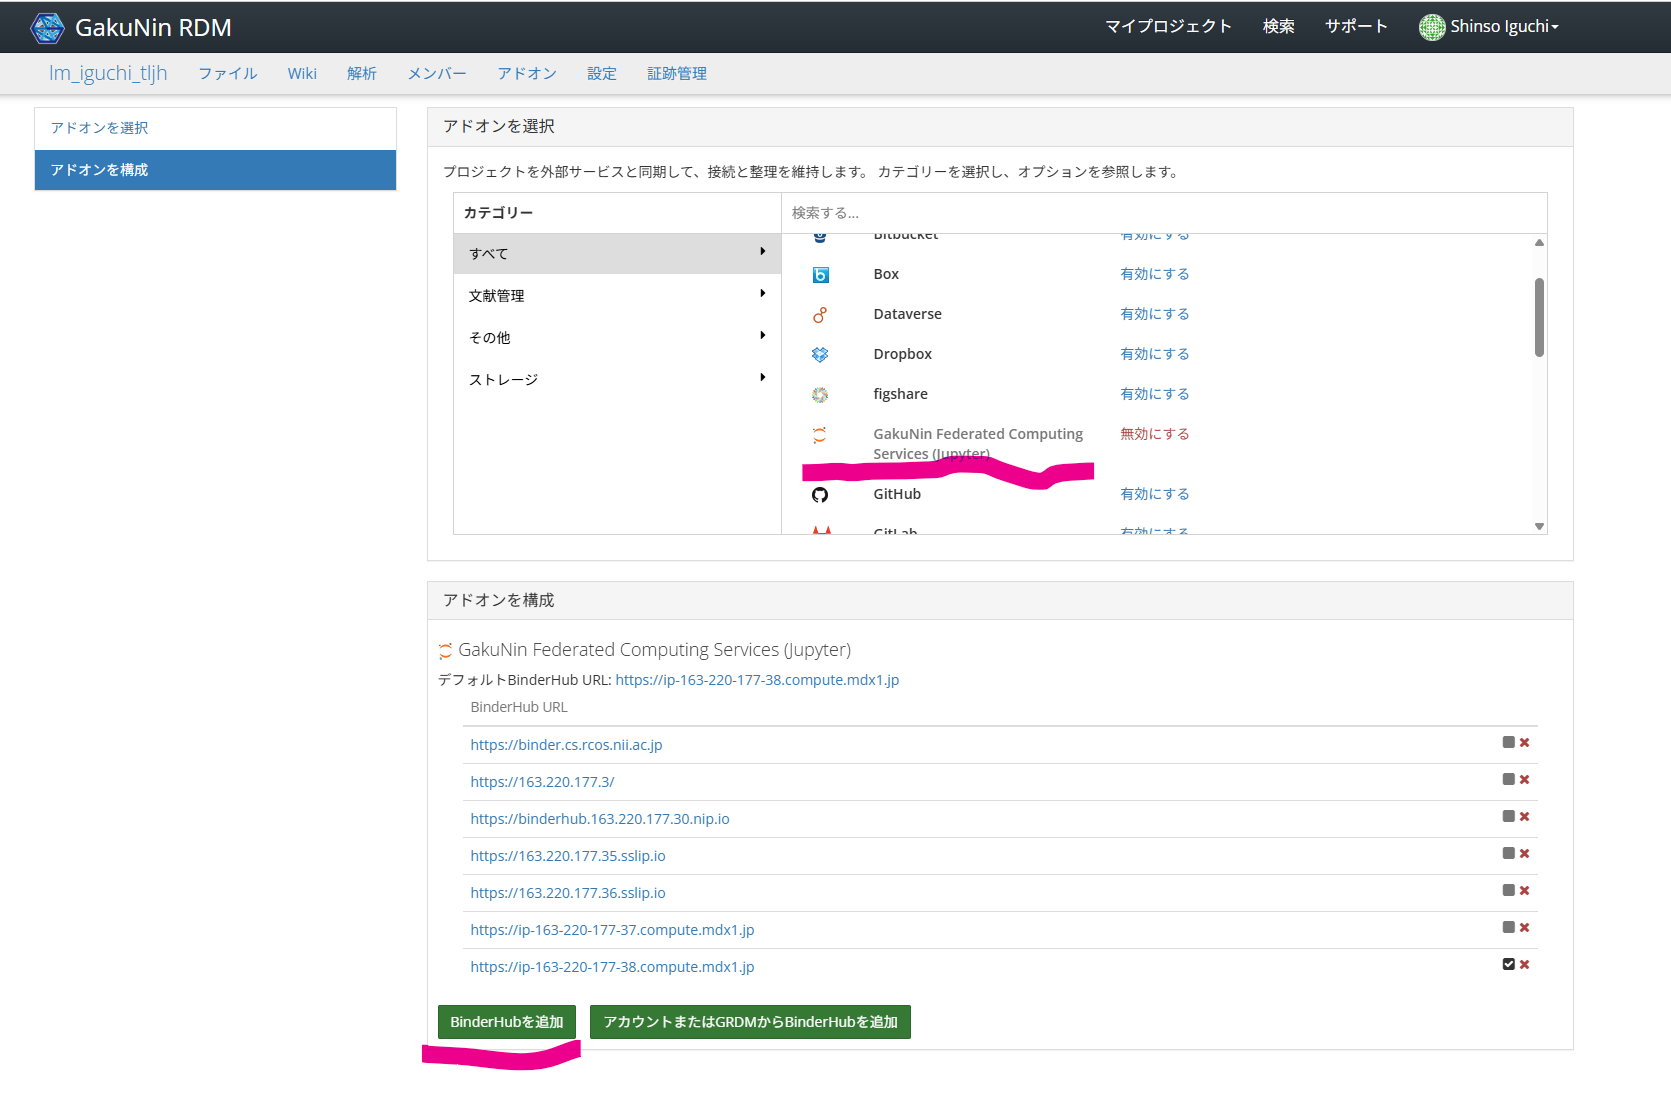
    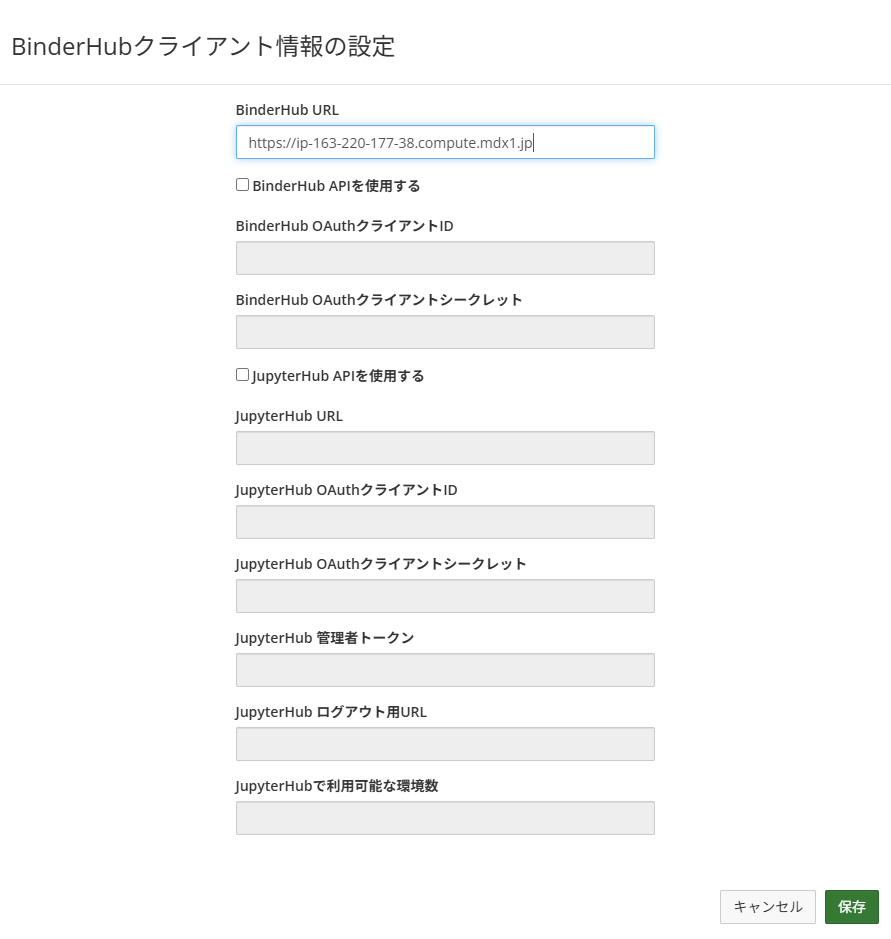

2. **Gakunin RDMから解析環境を作成**
    - 解析タブから、先ほど作成したBinderHubを選択し、解析環境のイメージを選んだら作成します。

    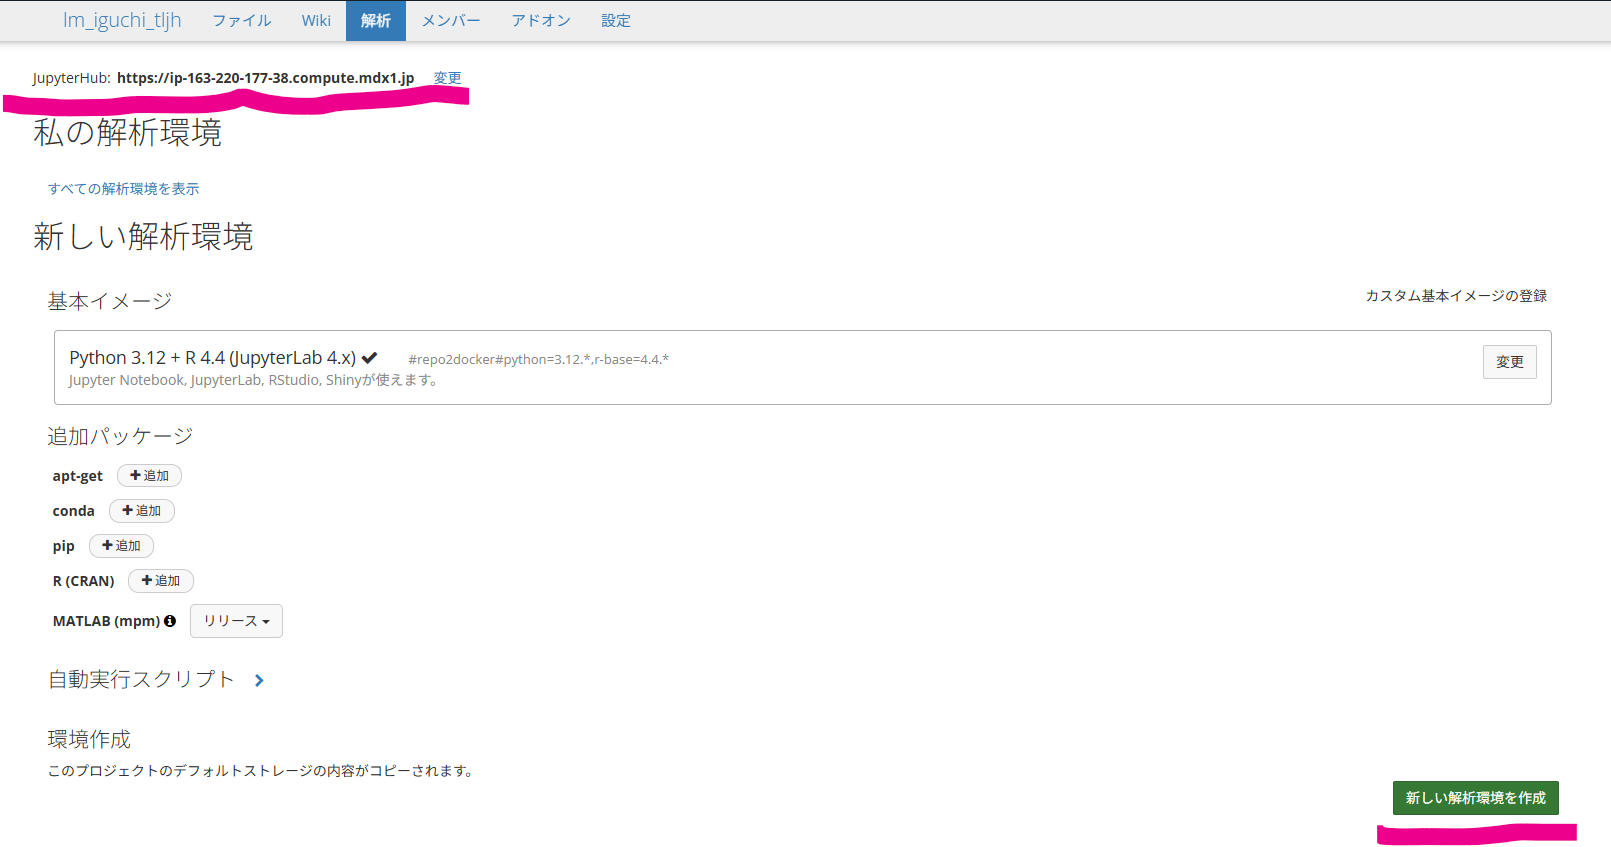

3. **TLJHに環境を作成**
    - Gakunin RDMで解析環境の作成を実行すると、自動的にTLJHに画面遷移し、TLJH上に環境を作成します。こちらは10分程度時間がかかります。
    作成し終わるとStatusにチェックがつきます。

    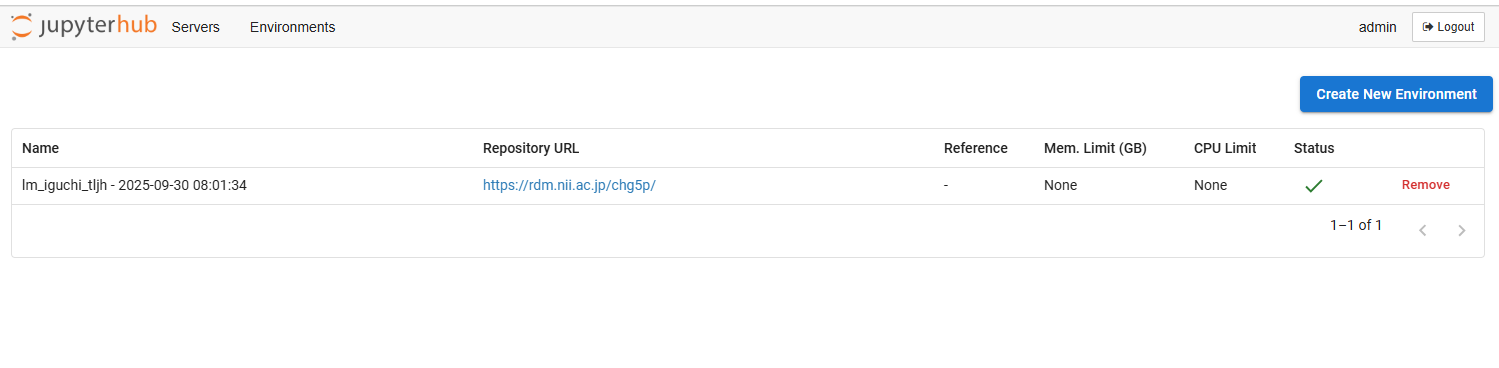

4. **TLJHにサーバを作成**
    - TLJH上に作成した環境を元にサーバを作成します。サーバタブをクリックし、Create New Serverからサーバを作成します。TLJH上に作成した環境を選択肢、サーバを作成したらOpen Serverをクリックして起動します。

    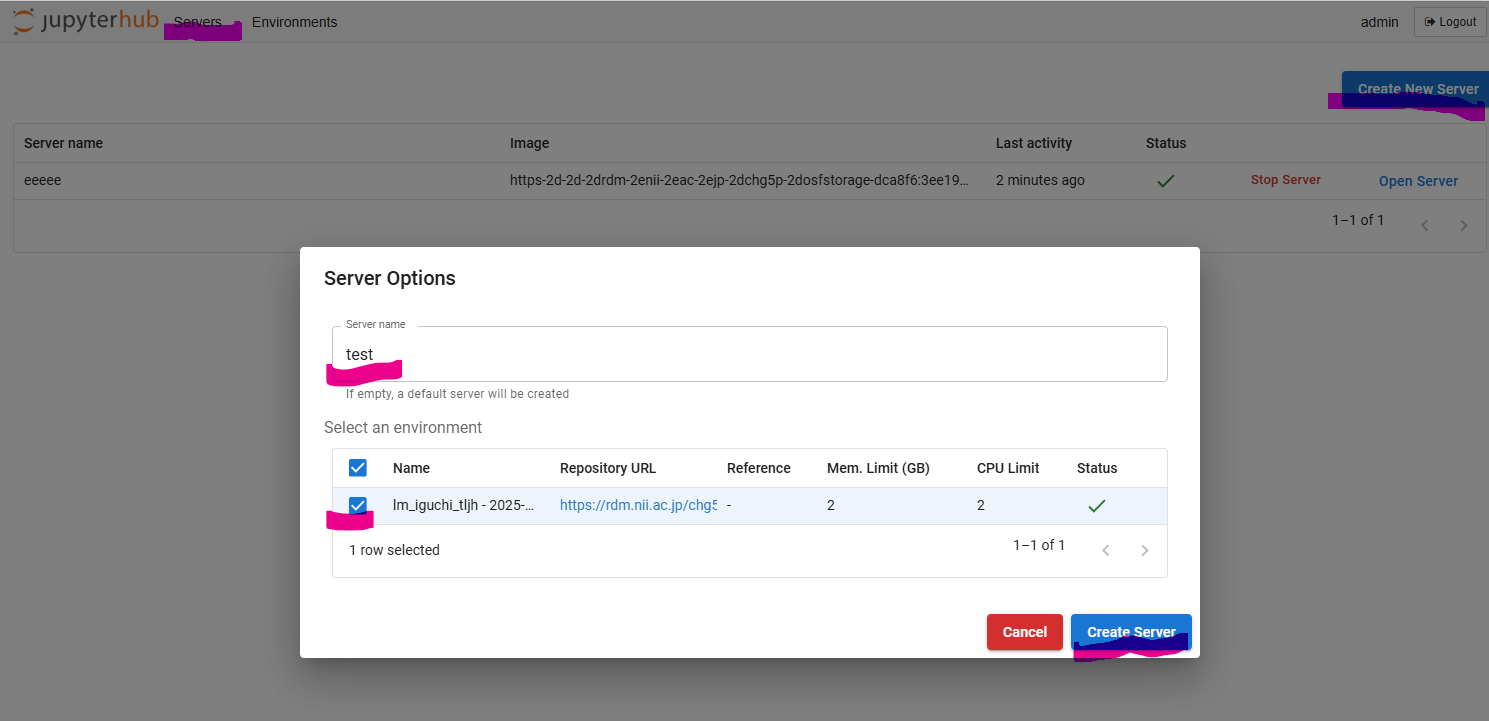
    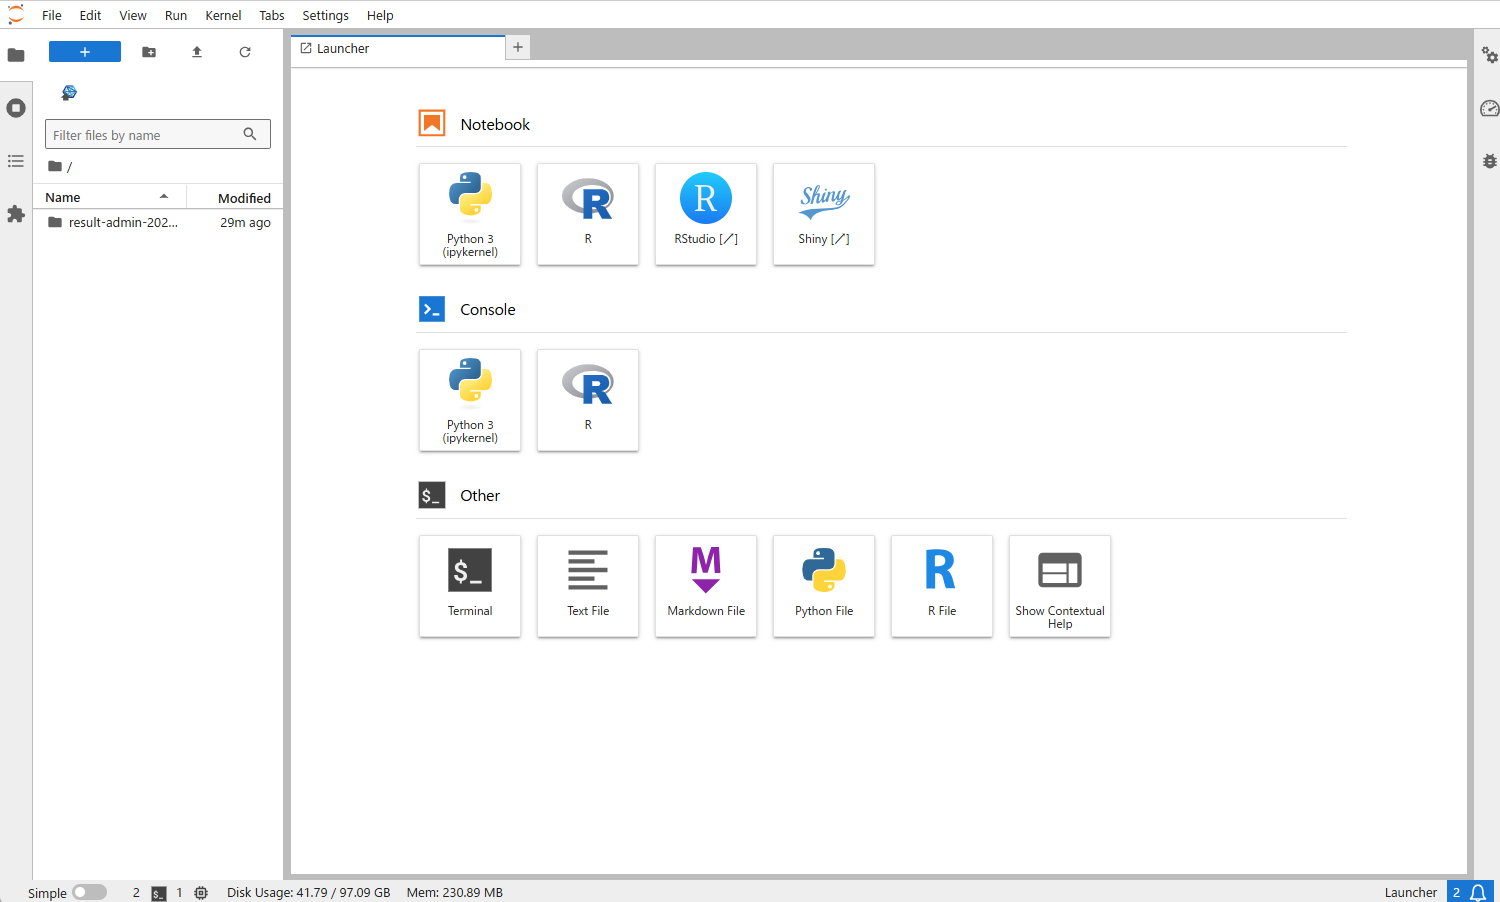

## 9. 補足情報

### よくある問題と解決策

1. **SSH接続エラー**
   - SSH鍵のパス確認: `chmod 600 ~/.ssh/id_rsa`
   - リモートサーバーの起動確認
   - ネットワーク設定確認

2. **Docker インストール失敗**
   - パッケージキャッシュの更新: `apt update`
   - 依存関係の確認

3. **JupyterHub起動失敗**
   - ポート競合の確認: `netstat -tlnp | grep :80`
   - ログファイルの確認: `journalctl -u jupyterhub -f`

4. **HTTPS証明書取得失敗**
   - DNS設定の確認
   - ファイアウォール設定（ポート443）
   - ドメイン名の伝播待ち（最大24時間）

### 手動確認コマンド

```bash
# サーバーでの状態確認
sudo systemctl status jupyterhub
sudo systemctl status docker
sudo journalctl -u jupyterhub -n 50

# TLJH設定確認
tljh-config show
```

### セキュリティ注意事項

<!-- - デフォルトパスワードを必ず変更 -->
- 適切なファイアウォール設定
- 定期的なバックアップとアップデート